In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow_dev/BayesFlow/')))

from src.python.settings import sum_config, summary_meta_validation, probability_meta_validation
from src.python.models import HierarchicalNormalSimulator
from src.python.helpers import variable_sizes, compute_eces_variable, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_eces_variable, plot_metric_marginalized

import bayesflow as bf
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

c:\Users\lasse\projects\BayesFlow_dev\BayesFlow\bayesflow\trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Model formulation

$$
\begin{align}
x_n &\sim \mathcal{N}(\theta_l, \sigma^2) \text{ for } n=1,...,N \\
\theta_l &\sim \mathcal{N}(\mu, \tau^2) \text{ for } l=1,...,L\\
\sigma^2 &\sim Half-Normal(\sigma_s)\\
\mu &\sim \mathcal{N}(\mu_0, \tau_0)\\
\tau^2 &\sim Half-Normal(\sigma_t)\\
\end{align}
$$

$$
\begin{align}
&\text{Null Model }M_0 \text{: } \mu=0\\
&\text{Alternative Model }M_1 \text{: } \mu \text{ allowed to differ from 0} \\
\end{align}
$$

# Set up simulators

In [2]:
n_clust_min = 1
n_clust_max = 100
n_obs_min = 1 
n_obs_max = 100

In [3]:
# Generative models
normal_model = HierarchicalNormalSimulator()

m1_simulator = partial(normal_model.generate_batch, model_index=0)
m2_simulator = partial(normal_model.generate_batch, model_index=1)
meta_model = bf.simulation.MultiGenerativeModel(
    [m1_simulator, m2_simulator], 
    shared_context_gen=partial(variable_sizes, 
                               n_clust_min, 
                               n_clust_max,
                               n_obs_min,
                               n_obs_max)
)

# Set up networks

In [4]:
# summary_net = bf.summary_networks.HierarchicalNetwork([
#     bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config), 
#     bf.networks.DeepSet(dense_s2_args=sum_config, dense_s3_args=sum_config)
#     ])
# probability_net = bf.inference_networks.PMPNetwork(num_models=2, dropout=False)

summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_1']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_1']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_1']['dense_equiv_args']), 
    bf.networks.DeepSet(dense_s1_args=summary_meta_validation['level_2']['inv_inner']['dense_inv_pre_pooling_args'],
                        dense_s2_args=summary_meta_validation['level_2']['inv_outer']['dense_inv_post_pooling_args'],
                        dense_s3_args=summary_meta_validation['level_2']['dense_equiv_args']) 
])
probability_net = bf.inference_networks.PMPNetwork(num_models=2, 
                                                   dense_args=probability_meta_validation['dense_args'], 
                                                   dropout=False)
amortizer = bf.amortizers.AmortizedModelComparison(probability_net, summary_net)

In [5]:
# Training steps
epochs=40
iterations_per_epoch=1000

# Checkpoint path for loading pretrained network and saving the final network

checkpoint_path = 'C:/Users/lasse/OneDrive/Ph.D/Projekte/hierarchical_model_comparison/checkpoints/01_calibration_validation/checkpoints_var_sizes'

trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=meta_model, 
    default_lr=0.0005,
    checkpoint_path=checkpoint_path
    )

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Train & validate

In [6]:
training_time_start = perf_counter()
losses = trainer.train_online(
    epochs=epochs, iterations_per_epoch=iterations_per_epoch, batch_size=32
    )
training_time_stop = perf_counter()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

100 epochs: 3.33 avg loss; 92min training time

with MN info: 

331-337 avg loss after 50 epochs with 0.0001 lr

329-334 avg loss after 50 epochs with 0.0005 lr

(5000, 45, 6, 1)
ECE = 0.012


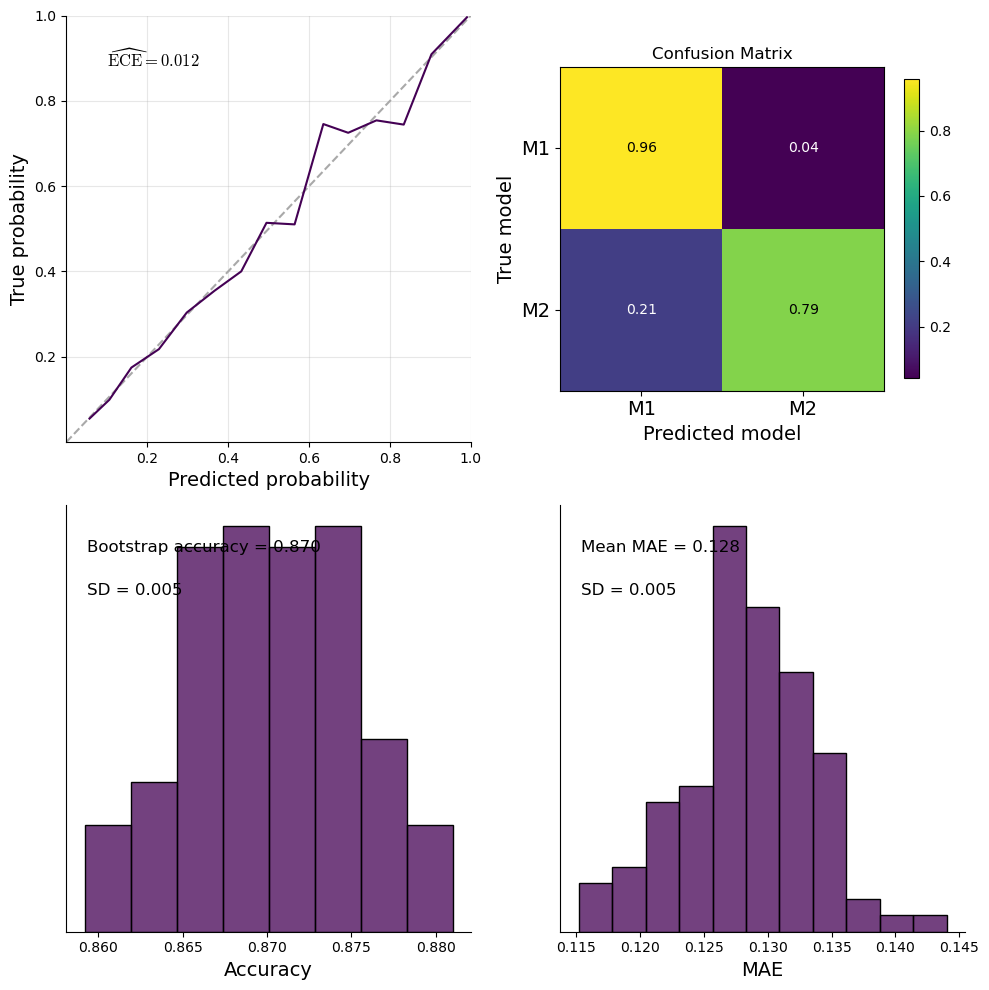

In [14]:
# Test performance with random n_clust and n_obs
val_data = trainer.configurator(meta_model(5000))
print(val_data['summary_conditions'].shape)
perf_tester(probability_net, summary_net, val_data, variable_sizes=True)

In [11]:
# fast validation

from src.python.helpers import calibration_curve_with_ece
from sklearn.metrics import mean_absolute_error

custom_range = [1,5,10,25,50,75,100]
#custom_range = [1]
eces = []

for l in custom_range:
    n = 1
    # Generate data
    meta_simulator = bf.simulation.MultiGenerativeModel(
        [m1_simulator, m2_simulator], 
        shared_context_gen=partial(variable_sizes, l, l+1, n, n+1)
        )
    data = trainer.configurator(meta_simulator(5000))
    print(data['summary_conditions'].shape)

    # Predict model probabilities
    split_direct_conditions = tf.split(data["direct_conditions"], 20)
    preds = []
    for i, x_chunk in enumerate(tf.split(data["summary_conditions"], 20)):
        embedding = summary_net(x_chunk)
        inference_net_input = np.concatenate([embedding, split_direct_conditions[i]], axis=1)
        preds.append(probability_net.posterior_probs(inference_net_input)[:, 1])
    m_soft = np.concatenate(preds)
    m_hard = (m_soft > 0.5).astype(np.int32)
    m_true = data["model_indices"][:, 1]

    # Compute metrics
    prob_true, prob_pred, ece = calibration_curve_with_ece(
        m_true, m_soft, n_bins=15
    )

    eces.append(ece)

[round(elem, 2) for elem in eces]

(5000, 1, 1, 1)
(5000, 5, 1, 1)
(5000, 10, 1, 1)
(5000, 25, 1, 1)
(5000, 50, 1, 1)
(5000, 75, 1, 1)
(5000, 100, 1, 1)


[0.12, 0.03, 0.04, 0.01, 0.01, 0.01, 0.01]

In [ ]:
# Validation (takes about 3h)
n_val_per_setting = 5000
get_accuracies_sbc = True  # Compute accuracies + sbc additionally to ECEs?

if not get_accuracies_sbc:
    eces = compute_eces_variable(
        probability_net,
        summary_net,
        trainer,
        m1_simulator,
        m2_simulator,
        n_val_per_setting,
        n_clust_min,
        n_clust_max,
        n_obs_min,
        n_obs_max,
    )

if get_accuracies_sbc:
    eces, accuracies, sbcs = compute_eces_variable(
        probability_net,
        summary_net,
        trainer,
        m1_simulator,
        m2_simulator,
        n_val_per_setting,
        n_clust_min,
        n_clust_max,
        n_obs_min,
        n_obs_max,
        add_accuracy_sbc=True,
    )

In [ ]:
# Export validation results
export_val_results = True

if export_val_results == True:
    local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo

    filename_eces = pd.Timestamp.today(tz=local_timezone).strftime("%Y_%m_%d_eces")
    filename_accuracies = pd.Timestamp.today(tz=local_timezone).strftime(
        "%Y_%m_%d_accuracies"
    )
    filename_sbcs = pd.Timestamp.today(tz=local_timezone).strftime("%Y_%m_%d_sbcs")
    val_folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "03_variable_sizes",
    )

    np.save(os.path.join(val_folder, filename_eces), eces)
    np.save(os.path.join(val_folder, filename_accuracies), accuracies)
    np.save(os.path.join(val_folder, filename_sbcs), sbcs)

In [5]:
# Import validation results
import_val_results = True

if import_val_results == True:
    filename_eces = "2023_06_21_eces.npy"
    filename_accuracies = "2023_06_21_accuracies.npy"
    filename_sbcs = "2023_06_21_sbcs.npy"
    val_folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "03_variable_sizes",
    )

    eces = np.load(os.path.join(val_folder, filename_eces))
    accuracies = np.load(os.path.join(val_folder, filename_accuracies))
    sbcs = np.load(os.path.join(val_folder, filename_sbcs))

Median ECE = 0.017968569239601502


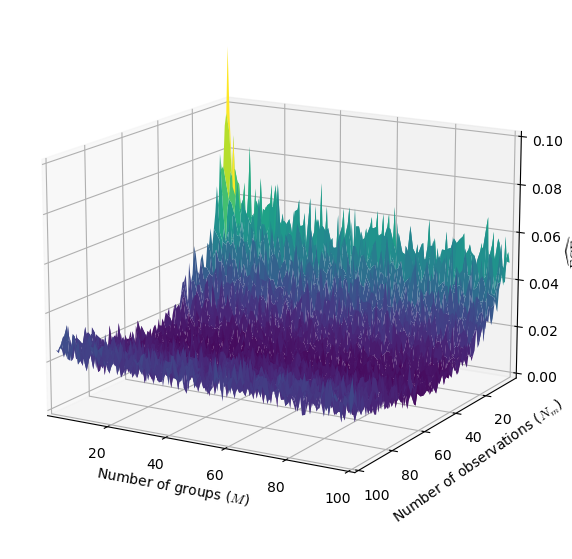

In [6]:
# Plot ECEs
plot_eces_variable(eces, n_clust_min, n_clust_max, n_obs_min, n_obs_max, save=True)

Median ECE = 0.883


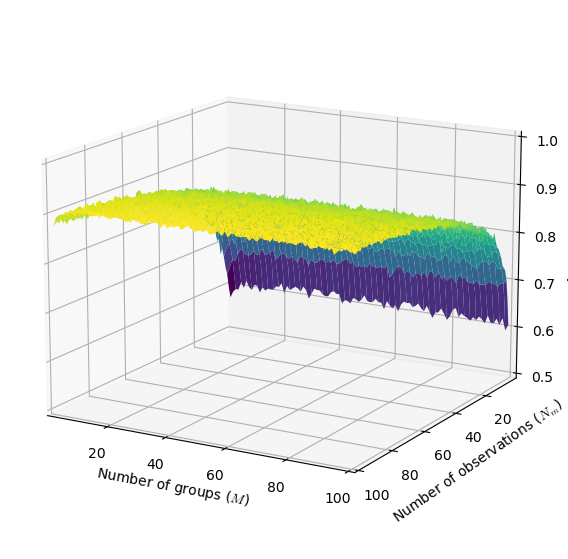

In [7]:
# Plot Accuracies
plot_eces_variable(
    accuracies,
    n_clust_min,
    n_clust_max,
    n_obs_min,
    n_obs_max,
    zlims=[0.5, 1],
    zlabel="Accuracy",
    save=True,
)

Median ECE = 0.0008911043405532837


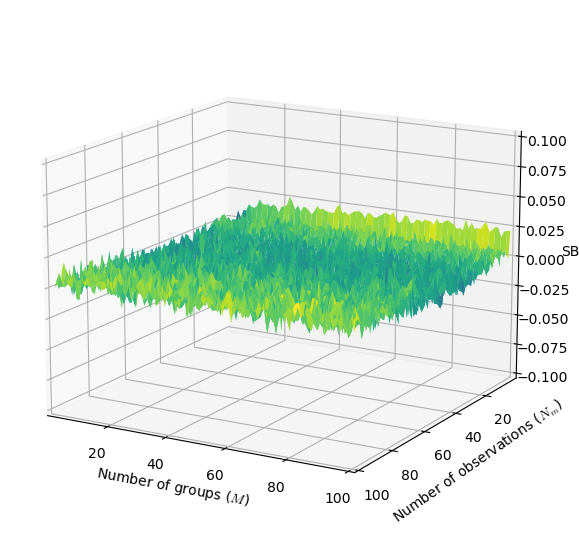

In [8]:
# Plot SBCs
plot_eces_variable(
    sbcs,
    n_clust_min,
    n_clust_max,
    n_obs_min,
    n_obs_max,
    zlims=[-0.1, 0.1],
    zlabel="SBC",
    save=True,
)

[0.02124243 0.02095091 0.02048057 0.01969289 0.01792866]
[0.042485   0.05794275 0.05137401 0.04701931 0.04561052]
[0.8446 0.86   0.8689 0.8723 0.8742]
[0.6088 0.6552 0.6876 0.7129 0.7327]
[-0.00289911 -0.00218877 -0.00118184 -0.0015516   0.00024664]
[ 0.01878397 -0.00190222  0.00205217  0.00521842  0.00422361]


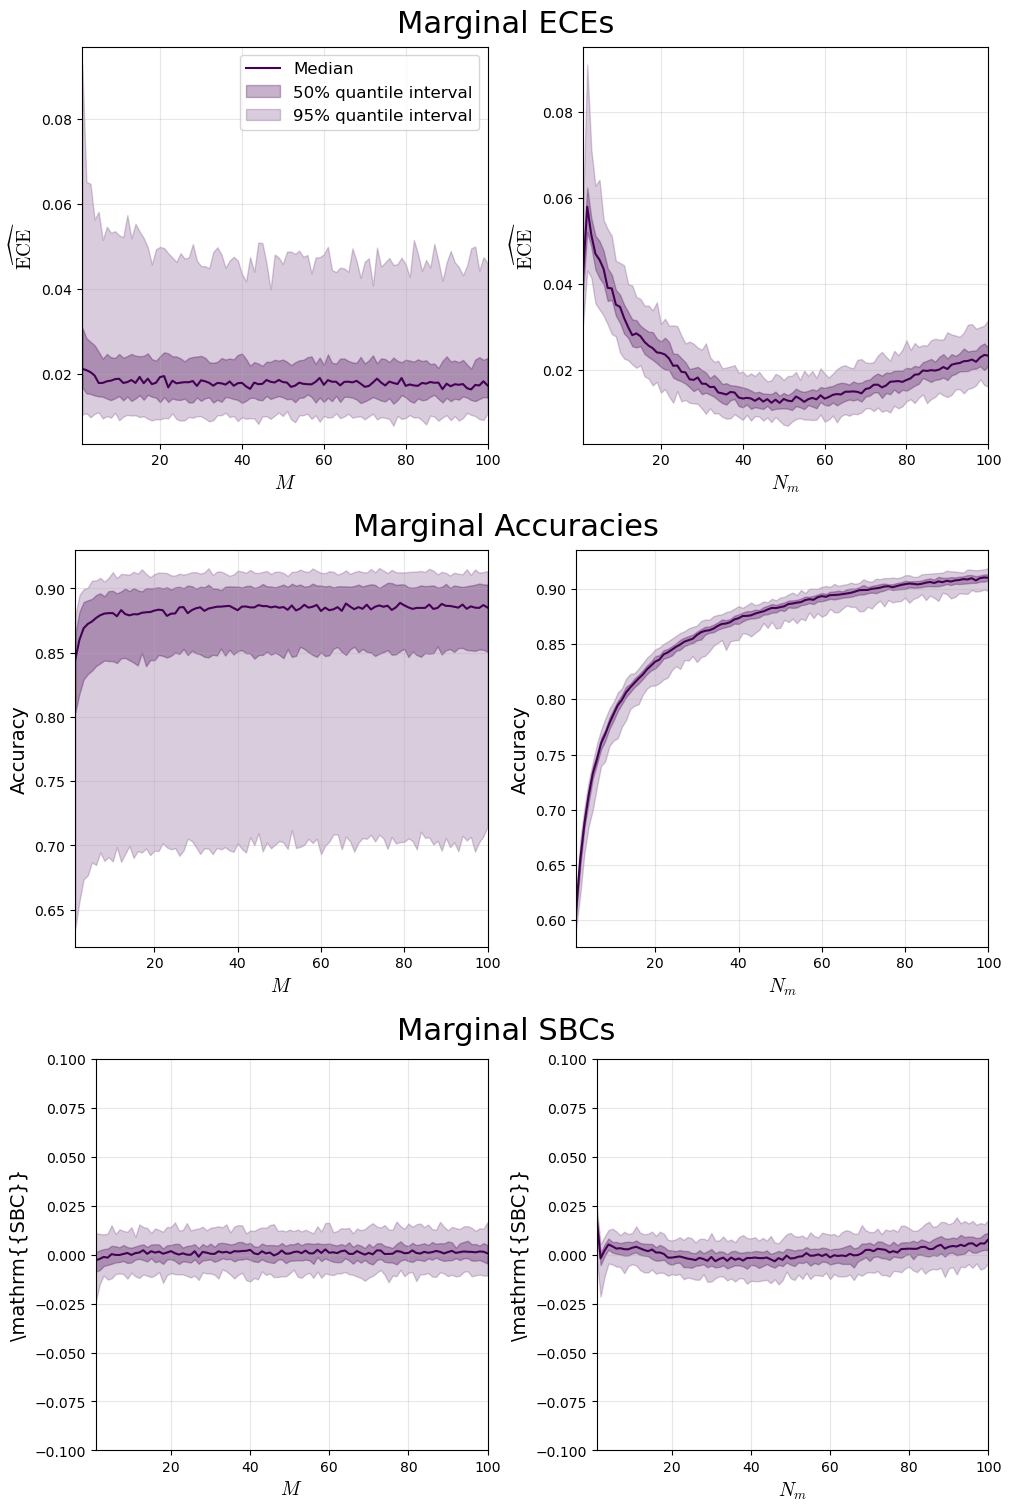

In [9]:
# plot all 6 plots for all 6 metrics in 1 plot
# todo: enable ax.set_ylim([0, 0.1]) in vizualization

fig = plt.figure(constrained_layout=True, figsize=(10, 15))
subfigs = fig.subfigures(nrows=3, ncols=1)
subfigure_titles = ["Marginal ECEs", "Marginal Accuracies", "Marginal SBCs"]

metrics_list = [eces, accuracies, sbcs]
names_list = ["ECE", "Accuracy", "SBC"]

# Use subfig to enable row titles
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfigure_titles[row], fontsize=22)

    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2)

    if row == 0:
        legend = True
    else:
        legend = False

    plot_metric_marginalized(
        metrics_list[row],
        n_clust_min,
        n_clust_max,
        n_obs_min,
        n_obs_max,
        x_axis=0,
        narrow_ci=[0.25, 0.75],
        wide_ci=[0.025, 0.975],
        metric=names_list[row],
        legend=legend,
        ax=axs[0],
    )
    plot_metric_marginalized(
        metrics_list[row],
        n_clust_min,
        n_clust_max,
        n_obs_min,
        n_obs_max,
        x_axis=1,
        narrow_ci=[0.25, 0.75],
        wide_ci=[0.025, 0.975],
        metric=names_list[row],
        legend=False,
        ax=axs[1],
    )

plt.savefig("marginals_variable_observations.pdf", dpi=300, bbox_inches="tight")

In [29]:
# Save training meta-information for bridge sampling comparison?
save_training_vars = False

if save_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "03_variable_sizes",
    )

    np.save(
        os.path.join(folder, "training_time_start"),
        training_time_start,
        allow_pickle=True,
    )
    np.save(
        os.path.join(folder, "training_time_stop"),
        training_time_stop,
        allow_pickle=True,
    )
    np.save(os.path.join(folder, "losses"), losses, allow_pickle=True)

In [ ]:
# Load ECE & accuracy data
import_metrics = False

if import_metrics:
    n_val_per_setting = 5000

    n_clust_min = 1
    n_clust_max = 100
    n_obs_min = 1
    n_obs_max = 100

    val_folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "03_variable",
    )

    ece_filename = "2022_12_17_eces_var_sizes.npy"
    eces = np.load(os.path.join(val_folder, ece_filename))

    accs_filename = "2022_12_17_accs_var_sizes.npy"
    accuracies = np.load(os.path.join(val_folder, accs_filename))

    sbcs_filename = ""
    sbcs = np.load(os.path.join(val_folder, sbcs_filename))

# Calculate Bayes factors for bridge sampling comparison

In [ ]:
# Import training meta-information? (if network was loaded from checkpoint)
import_training_vars = False

if import_training_vars:
    folder = os.path.join(
        os.path.dirname(os.path.dirname(os.getcwd())),
        "data",
        "01_calibration_validation",
        "03_variable",
    )

    training_time_start = np.load(
        os.path.join(folder, "training_time_start.npy"), allow_pickle=True
    )
    training_time_stop = np.load(
        os.path.join(folder, "training_time_stop.npy"), allow_pickle=True
    )
    losses = np.load(os.path.join(folder, "losses.npy"), allow_pickle=True)

In [8]:
# Import test data
val_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())),
    "data",
    "02_bridge_sampling_comparison",
    "nested_models",
)
data_filename = "test_data.npy"
test_data = np.load(os.path.join(val_folder, data_filename), allow_pickle=True).item()

In [9]:
# Get NN predictions
comparison_results = get_preds_and_bfs(
    probability_net,
    summary_net,
    test_data,
    training_time_start,
    training_time_stop,
    losses,
)
comparison_results.head(5)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.818523,0.181477,0,0.221712,5517.759375,0.00334,0.333168
1,2,0,0.867150,0.132850,0,0.153203,5517.759375,0.00334,0.333168
2,3,0,0.891498,0.108502,0,0.121708,5517.759375,0.00334,0.333168
3,4,1,0.004863,0.995137,1,204.620776,5517.759375,0.00334,0.333168
4,5,0,0.888639,0.111361,0,0.125317,5517.759375,0.00334,0.333168


In [10]:
# Export results
local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
filename = pd.Timestamp.today(tz=local_timezone).strftime("%Y_%m_%d_BF_NN_variable")
comparison_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())),
    "data",
    "02_bridge_sampling_comparison",
    "nested_models",
)

comparison_results.to_csv(os.path.join(comparison_folder, filename), index=False)